<a href="https://colab.research.google.com/github/egagli/amath563/blob/main/labs/4/lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 3: Convolutional Neural Nets (CNNs)

## Assignment: LeNet5 Implementation

In [1]:
import torch
import torchvision
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import tqdm

batch_size_train = 100 #Define train batch size
batch_size_test  = 100 #Define test batch size (can be larger than train batch size)


# Use the following code to load and normalize the dataset
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([torchvision.transforms.Resize((32, 32)),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.5,), (0.5,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([torchvision.transforms.Resize((32, 32)),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.5,), (0.5,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [2]:
class LeNet5(nn.Module):

    def __init__(self):
        super(LeNet5, self).__init__()
        
        #define LeNet5

        # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=0)
        self.tanh1 = nn.Tanh()
        
        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2,stride=2)
     
        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.tanh2 = nn.Tanh()
        
        # Max pool 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2,stride=2)

        self.cnn3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1, padding=0)
        self.tanh3 = nn.Tanh()

        # Fully connnected 2
        self.fc1 = nn.Linear(120, 84) 

        # Softmax
        self.fc2 = nn.Linear(84, 10) 


    def forward(self, x):
        #Define forward pass

        # Input x dimensions: # 32x32x1
        # Set 1
        out = self.cnn1(x) # 28x28x6
        out = self.tanh1(out) 
        out = self.maxpool1(out) # 14x14x6
        
        # Set 2
        out = self.cnn2(out) # 10x10x16
        out = self.tanh2(out)   
        out = self.maxpool2(out) # 5x5x16

        out = self.cnn3(out) # 120
        out = self.tanh3(out)           
        
        #Flatten
        out = out.view(out.size(0), -1) # 120
        #Dense
        out = self.fc1(out) # 84
        out = self.fc2(out) # 10
        
        return out

In [3]:
#Definition of hyperparameters
num_epochs = 5
# Cross Entropy Loss 
error = nn.CrossEntropyLoss()

# Adam Optimizer
model = LeNet5()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [4]:
# initialize arrays to hold loss and accuracy data
train_loss_list = np.zeros((num_epochs,))
accuracy_list = np.zeros((num_epochs,))

for epoch in tqdm.trange(num_epochs):
  total_train_loss = 0
  total_val_loss = 0

  for imgs,labels in train_loader:
    # calculate training loss on model
    y_pred = model(imgs)
    loss = error(y_pred, labels)
    total_train_loss += loss
    
    # zero gradients, backwards pass, and step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  train_loss_list[epoch] = total_train_loss/len(train_loader)

  # validation
  #for imgs,labels in val_loader:
   # y_pred = model(imgs)
   # loss = loss_fn(y_pred, labels)
   # total_val_loss += loss
  #val_loss_list[epoch] = total_val_loss/len(val_loader)

  # Calculate accuracy on test set
  imgs_test, labels_test = next(iter(test_loader))
  with torch.no_grad():
    y_pred = model(imgs_test)
    correct = (torch.argmax(y_pred, dim=1) == labels_test).type(torch.FloatTensor)
    accuracy_list[epoch] = correct.mean()

100%|██████████| 5/5 [02:46<00:00, 33.39s/it]


Text(0.5, 0.98, 'Adam \n lr = 0.001 epochs = 5 \n Max Accuracy = 1.000')

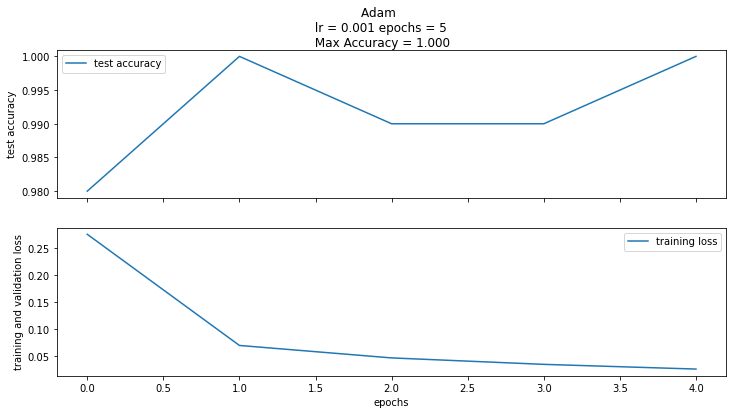

In [5]:
# plot test accuracy and training loss
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

ax1.plot(accuracy_list,label='test accuracy')
ax1.set_ylabel("test accuracy")
ax1.legend()
ax2.plot(train_loss_list,label='training loss')
#ax2.plot(val_loss_list,label='validation loss')
ax2.legend()
ax2.set_ylabel("training and validation loss")
ax2.set_xlabel("epochs");
fig.suptitle(f'Adam \n lr = 0.001 epochs = {num_epochs} \n Max Accuracy = {max(accuracy_list):.3f}')

In [6]:
# get images and labels for test set
imgs_test, labels_test = next(iter(test_loader))
with torch.no_grad():
  y_pred = model(imgs_test)

In [7]:
# get guesses
guesses = torch.argmax(y_pred, dim=1) 

In [8]:
# get probabilities
smax=nn.Softmax(dim=1)
probability,_ = torch.max(smax(y_pred),dim=1) 

Text(0.5, 0.98, 'LeNet MNIST Classification Test Accuracy')

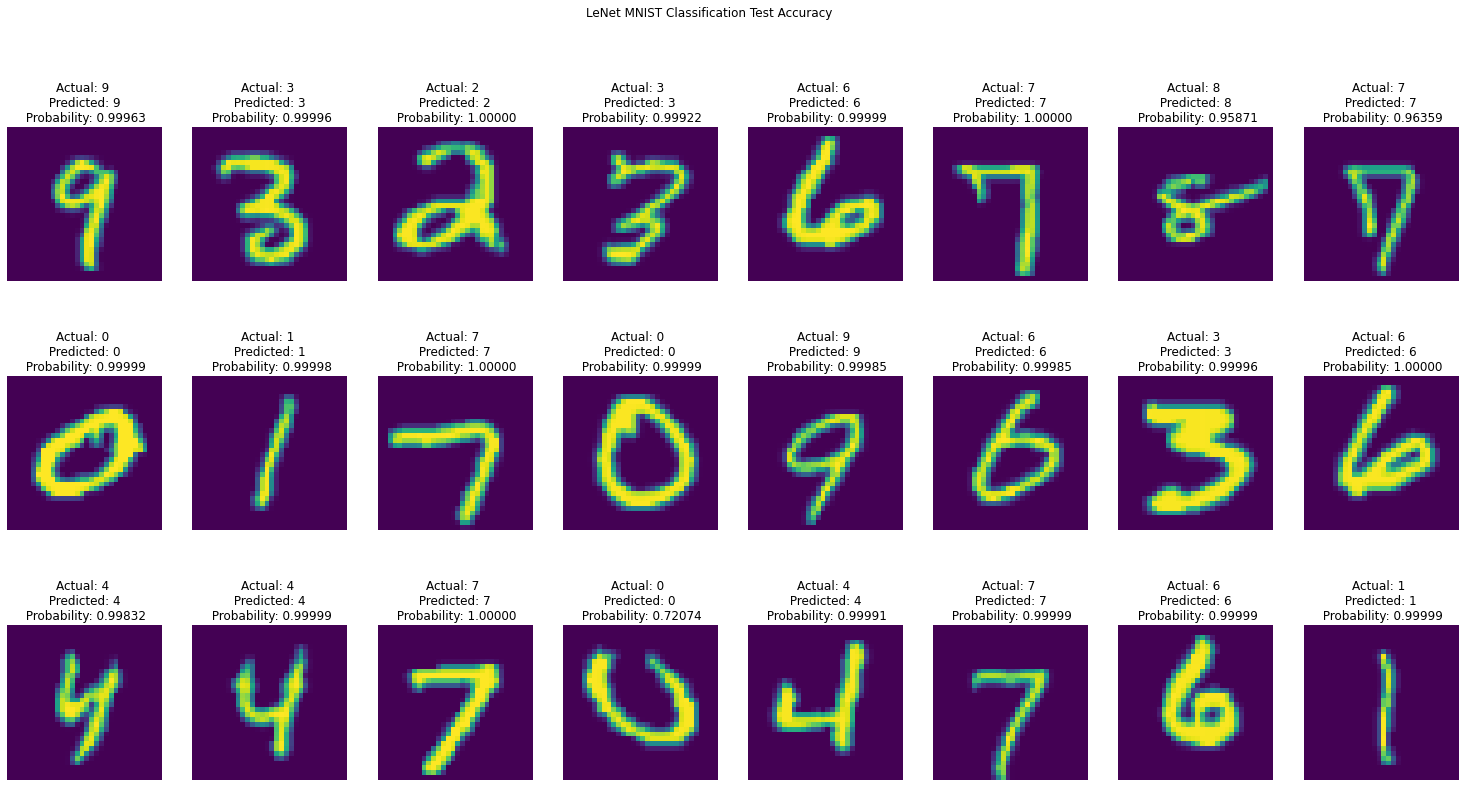

In [9]:
# plot classification accuracy
f,ax=plt.subplots(3,8,figsize=(26,13))
for i,(axs,predicted,true,prob) in enumerate(zip(ax.reshape(-1),guesses,labels_test,probability)):
  axs.imshow(imgs_test[i][0])
  axs.set_title(f'Actual: {true} \n Predicted: {predicted} \n Probability: {prob:0.5f}')
  axs.axis('off')
f.suptitle('LeNet MNIST Classification Test Accuracy')